In [1]:
# Basics
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# TensorFlow/Keras (Keras layers below)
from tensorflow.keras.utils import set_random_seed, to_categorical
from tensorflow import keras
from keras.models import load_model
# set_random_seed(1234) # set the seeds for Python, NumPy, and TensorFlow in order to reproduce the results

# Custom
import sys
sys.path.insert(0, '../src/utils')
from trace_handler import TraceHandler
sys.path.insert(0, '../src/modeling')
from genetic_tuner import GeneticTuner

# Suppress TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # 1 for INFO, 2 for INFO & WARNINGs, 3 for INFO & WARNINGs & ERRORs

In [2]:
# Train
train_th = TraceHandler('/prj/side_channel/PinataTraces/CURR/D1-K1_50k_500MHz + Resampled at 168MHz.trs')    
    
BYTE_IDX = 0
N_CLASSES = 256
VAL_PERC = 0.1

x_train_tot = train_th.get_traces()
y_train_tot = train_th.get_specific_labels(BYTE_IDX)
y_train_tot = to_categorical(y_train_tot, N_CLASSES)

x_train, x_val, y_train, y_val = train_th.generate_train_val(BYTE_IDX, val_perc=VAL_PERC)
y_train = to_categorical(y_train, N_CLASSES)
y_val = to_categorical(y_val, N_CLASSES)

# Test
test_th = TraceHandler('/prj/side_channel/PinataTraces/CURR/D1-K2_50k_500MHz + Resampled at 168MHz.trs')

x_test, y_test = test_th.generate_test(BYTE_IDX) 
y_test = to_categorical(y_test, N_CLASSES)

test_plaintexts = test_th.get_plaintexts()
true_key_byte = test_th.get_key()[BYTE_IDX]

Labeling traces: 100%|██████████| 50000/50000 [00:15<00:00, 3316.37it/s] 


In [3]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

HP_CHOICES = {#'kernel_initializer': ['random_normal', 'random_uniform', 
              #                       'truncated_normal', 
              #                       'zeros', 'ones', 
              #                       'glorot_normal', 'glorot_uniform',
              #                       'he_normal', 'he_uniform',
              #                       'identity', 'orthogonal', 'constant', 'variance_scaling'],
              'kernel_initializer': ['random_normal', 'random_uniform', 'truncated_normal', 'he_normal', 'he_uniform'],  
              'activation':         ['relu', 'tanh'],
              'hidden_layers':      [1, 2, 3, 4, 5],
              'hidden_neurons':     [100, 200, 300, 400, 500],
              'dropout_rate':       [0.0, 0.2, 0.4],
              'optimizer':          [SGD, Adam, RMSprop],
              'learning_rate':      [1e-3, 1e-4, 1e-5],
              'batch_size':         [50, 100, 200, 500]}    

In [4]:
GENERATIONS = 20
EPOCHS = 100

gt = GeneticTuner(hp_choices=HP_CHOICES, pop_size=10, selection_perc=0.3)
population = gt.populate()

best_acc = []
avg_acc = []
diff_acc = []

for i in range(GENERATIONS):
    print()
    print(f'-------------------- Generation {i+1}/{GENERATIONS} --------------------')
    
    evaluation = gt.evaluate(population, x_train, y_train, EPOCHS, x_val, y_val) # list of tuple Individual-val_acc
    
    parents = gt.select(evaluation) # list of 2 Individual objects
    
    if i != GENERATIONS - 1:
        population = gt.evolve(parents) # list of pop_size Individual objects
    
    gen_best = evaluation[0][1]
    print(f'Gen Best: {gen_best}')
    
    gen_avg = np.mean(np.array([ev[1] for ev in evaluation]))
    print(f'Gen Avg: {gen_avg}')
    
    best_acc.append(gen_best)
    avg_acc.append(gen_avg)
    diff_acc.append(abs(gen_best - gen_acc))


-------------------- Generation 1/20 --------------------
Training individual 1/10...
Training individual 2/10...
Training individual 3/10...
Training individual 4/10...
Training individual 5/10...
Training individual 6/10...
Training individual 7/10...
Training individual 8/10...
Training individual 9/10...
Training individual 10/10...
--- Generation Results: [0.07320000231266022, 0.06260000169277191, 0.05180000141263008, 0.040800001472234726, 0.039799999445676804, 0.025200000032782555, 0.014399999752640724, 0.004600000102072954, 0.00419999985024333, 0.003800000064074993]

-------------------- Generation 2/20 --------------------
Training individual 1/10...
Training individual 2/10...
Training individual 3/10...
Training individual 4/10...
Training individual 5/10...
Training individual 6/10...
Training individual 7/10...
Training individual 8/10...
Training individual 9/10...
Training individual 10/10...
--- Generation Results: [0.11180000007152557, 0.08479999750852585, 0.0794000029

In [ ]:
f, ax = plt.subplots(3, 1, figsize=(10, 8))

ax[0].plot(best_acc, color='r', marker='o')
ax[0].set_title('Best accuracy')
ax[0].grid()

ax[1].plot(gen_acc, color='g', marker='o')
ax[1].set_title('Average accuracy')
ax[1].grid()

ax[2].plot(diff_acc, color='b', marker='o')
ax[2].set_title('Difference between best accuracy and average accuracy')
ax[2].grid()

plt.show()

In [5]:
# from datetime import datetime

# best_individual, best_val_acc = evaluation[0]

# now = datetime.now()
# BEST_MODEL_PATH = '../saved_models/' + now.strftime('%m%d%Y_%H%M')
# best_individual.save_model(BEST_MODEL_PATH)

# print(f'Best val_acc: {best_val_acc}')

In [6]:
# from tensorflow import keras
# # from keras.models import load_model

# # print('Loading the best model...')
# # best_model = load_model(BEST_MODEL_PATH)

# best_individual.final_train(x_train_tot, y_train_tot)

In [7]:
best_individual, best_val_acc = evaluation[0]
best_hp = best_individual.get_hp()
best_hp

{'kernel_initializer': 'random_normal',
 'activation': 'relu',
 'hidden_layers': 2,
 'hidden_neurons': 200,
 'dropout_rate': 0.2,
 'optimizer': keras.optimizer_v2.adam.Adam,
 'learning_rate': 0.001,
 'batch_size': 50}

In [8]:
from guessing_entropy import guessing_entropy

GE_EPOCHS = 100

ge = guessing_entropy(network_type='MLP',
                      hp=best_hp,
                      epochs=GE_EPOCHS,
                      x_train_tot=x_train_tot,
                      y_train_tot=y_train_tot,
                      x_test_tot=x_test,
                      test_plaintexts_tot=test_plaintexts,
                      true_key_byte=true_key_byte,
                      byte_idx=BYTE_IDX,
                      n_exp=10)

100%|██████████| 10/10 [05:21<00:00, 32.15s/it]


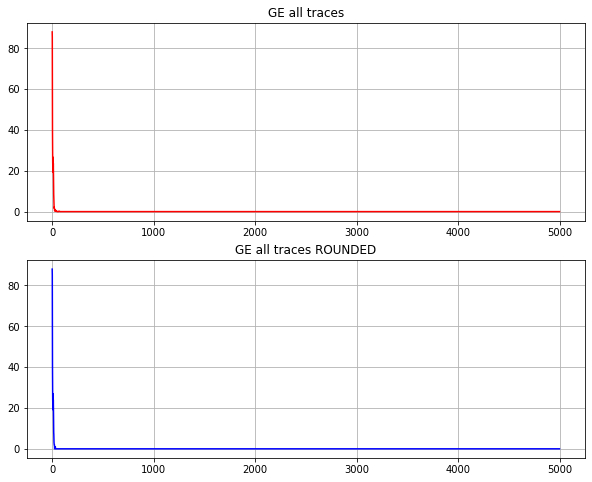

In [9]:
f, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(ge, color='r')
ax[0].set_title('GE all traces')
ax[0].grid()

ax[1].plot(np.round(ge), color='b')
ax[1].set_title('GE all traces ROUNDED')
ax[1].grid()

plt.show()

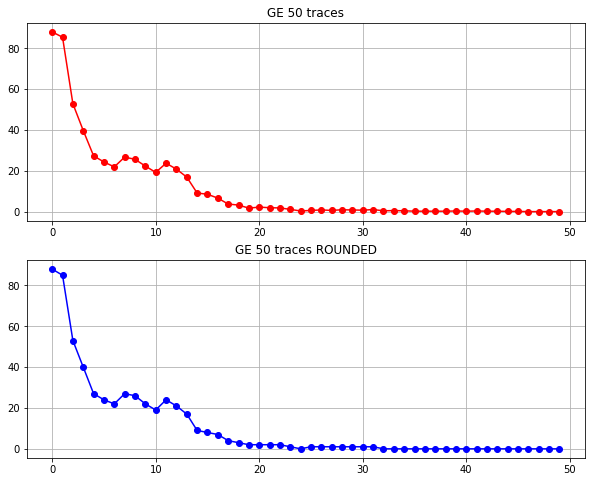

In [12]:
N_TRACES = 50

f, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(ge[:N_TRACES], color='r', marker='o')
ax[0].set_title(f'GE {N_TRACES} traces')
ax[0].grid()

ax[1].plot(np.round(ge[:N_TRACES]), color='b', marker='o')
ax[1].set_title(f'GE {N_TRACES} traces ROUNDED')
ax[1].grid()

plt.show()